Завдання №7

Побудувати автокодувальник для розпізнавання рукописних цифр  з шумом з використанням Pytorch
Вивести результати розпізнавання та графік функції втрат.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 128
epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clip(noisy_imgs, 0., 1.)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 663kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.10MB/s]


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
losses = []
for epoch in range(epochs):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0591
Epoch [2/10], Loss: 0.0337
Epoch [3/10], Loss: 0.0285
Epoch [4/10], Loss: 0.0261
Epoch [5/10], Loss: 0.0242
Epoch [6/10], Loss: 0.0228
Epoch [7/10], Loss: 0.0218
Epoch [8/10], Loss: 0.0210
Epoch [9/10], Loss: 0.0204
Epoch [10/10], Loss: 0.0198


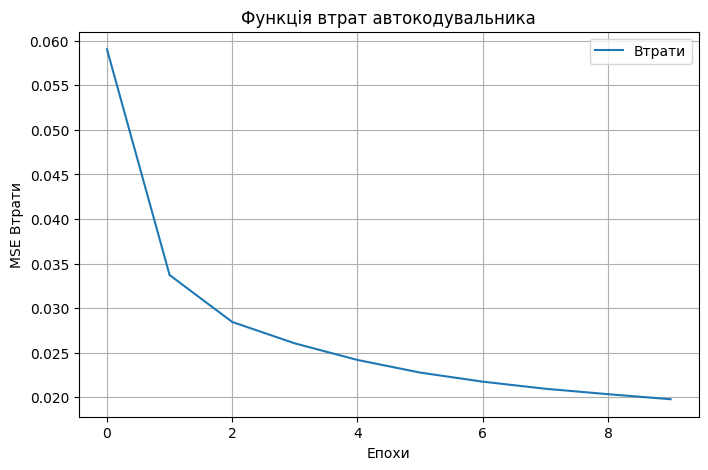

In [10]:
plt.figure(figsize=(8,5))
plt.plot(losses, label='Втрати')
plt.xlabel("Епохи")
plt.ylabel("MSE Втрати")
plt.title("Функція втрат автокодувальника")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def show_images(noisy, output, original, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].squeeze().cpu(), cmap='gray')
        plt.axis('off')
        if i == 0: ax.set_title('З шумом')
        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(output[i].squeeze().cpu().detach(), cmap='gray')
        plt.axis('off')
        if i == 0: ax.set_title('Розпізнано')
        # Original
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(original[i].squeeze().cpu(), cmap='gray')
        plt.axis('off')
        if i == 0: ax.set_title('Оригінал')
    plt.tight_layout()
    plt.show()

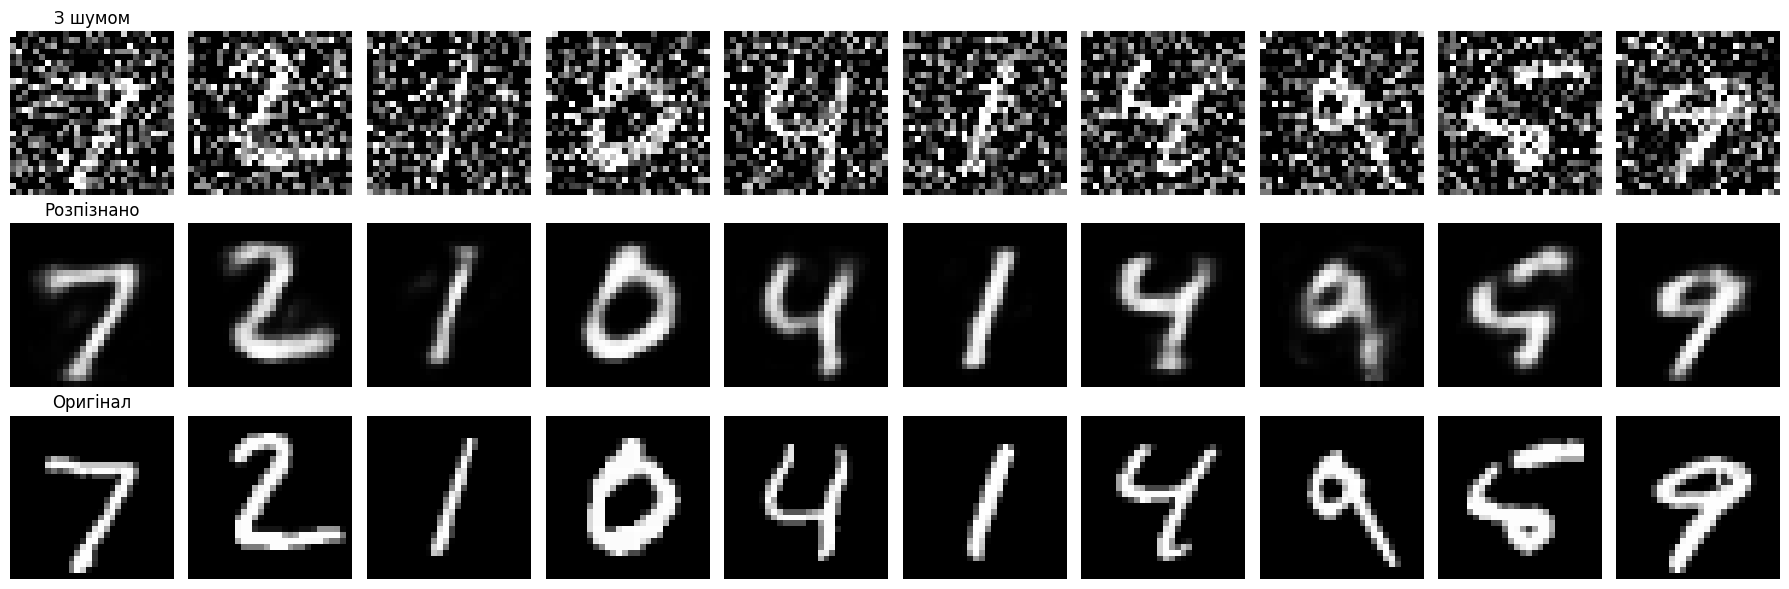

In [12]:
test_imgs, _ = next(iter(test_loader))
noisy_test = add_noise(test_imgs).to(device)
with torch.no_grad():
    denoised = model(noisy_test.to(device))

show_images(noisy_test, denoised, test_imgs.to(device))

Висновок

У ході лабораторної роботи було реалізовано автокодувальник на базі бібліотеки PyTorch для розпізнавання та відновлення рукописних цифр із зашумлених зображень. Проведено навчання моделі на датасеті MNIST із додаванням гаусівського шуму до вхідних даних. Аналіз графіка функції втрат показав поступове зменшення похибки, що свідчить про ефективність навчання, тоді як візуалізація результатів підтвердила здатність моделі відновлювати оригінальні зображення з високим ступенем точності. Результати роботи були завантажені на Github.